<a href="https://colab.research.google.com/github/archit36/IIScProject/blob/main/Group2_file1_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development and Optimization of Deep Q-Networks for Autonomous Lunar Lander Control

The project focuses on designing and optimizing a Deep Q-Network (DQN) to autonomously control a lunar lander in a simulated environment. The primary challenge is to enable the lander to reach its target safely by learning optimal policies for thrust control, orientation, and landing speed.

# Background Information

**Domain Information:**
 Lunar lander control is a classic problem in reinforcement learning, where the objective is to safely land a spacecraft on the moon's surface with minimal fuel consumption and without crashing. Deep Q-Networks (DQNs) are utilized to solve such complex control problems through learning-based approaches.

**Problem Description:**
The task is to design a DQN model that can efficiently control the lunar lander in a 2D environment, managing its descent and landing. The challenges include handling continuous state spaces, balancing exploration and exploitation, and avoiding catastrophic failures during training.


# Current Benchmark

The benchmarks for DQN on the Lunar Lander problem include:

•	**Original DQN (Mnih et al., 2015):** Basic implementation with experience replay and target networks.

•	**Double DQN:** Reduces overestimation bias, leading to more stable training.

•	**Dueling DQN:** Separates the state value and action advantage, enhancing learning efficiency.

• **Rainbow DQN:** Integrates multiple improvements such as prioritized experience replay, multi-step learning, and distributional RL.


#Original DQN (Mnih et al., 2015): Basic implementation with experience replay and target networks.

In [ ]:
# @title Update/Upgrade the system and install libs
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [ ]:
# @title Install dependencies
!pip install rarfile --quiet
!pip install 'stable-baselines3[extra]' --quiet
!pip install ale-py --quiet
!pip install swig
!pip install gym --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Importing necessary libraries

In [ ]:
# Imports
import io
import os
import glob
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder

Now, let us setup our model and the DQN algorithm.

In [ ]:
nn_layers = [64, 64]  # This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                      # If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001  # This is the step-size with which the gradient descent

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)
# You can also load other environments like cartpole, MountainCar, Acrobot.
# Refer to https://gym.openai.com/docs/ for descriptions.

# For example, if you would like to load Cartpole,
# just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=64,  # for simplicity, we are not doing batch update.
            buffer_size=10000,  # size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=1,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = 1,  # initial value of random action probability
            exploration_fraction = 0.5,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc.
# Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
# for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

# The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine

### Train the model

In [ ]:
model.learn(total_timesteps=10000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=8910, episode_reward=-590.07 +/- 153.96
Episode length: 68.40 +/- 12.53
New best mean reward!
Eval num_timesteps=18910, episode_reward=-530.16 +/- 122.69
Episode length: 62.40 +/- 12.13
New best mean reward!
Eval num_timesteps=28910, episode_reward=-619.39 +/- 192.25
Episode length: 69.40 +/- 10.59
Eval num_timesteps=38910, episode_reward=-602.77 +/- 173.34
Episode length: 66.40 +/- 12.34
Eval num_timesteps=48910, episode_reward=-602.33 +/- 158.49
Episode length: 65.20 +/- 10.85
Eval num_timesteps=58910, episode_reward=-603.68 +/- 115.90
Episode length: 70.80 +/- 7.60
Eval num_timesteps=68910, episode_reward=-696.68 +/- 375.94
Episode length: 82.00 +/- 30.28
Eval num_timesteps=78910, episode_reward=-596.18 +/- 155.36
Episode length: 65.60 +/- 11.07
Eval num_timesteps=88910, episode_reward=-606.39 +/- 127.55
Episode length: 70.60 +/- 9.65
Eval num_timesteps=98910, episode_reward=-563.93 +/- 150.65
Episode length: 64.00 +/- 10.68


In [ ]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


KeyboardInterrupt: 

Now, let us look at the visual performance of the lander.

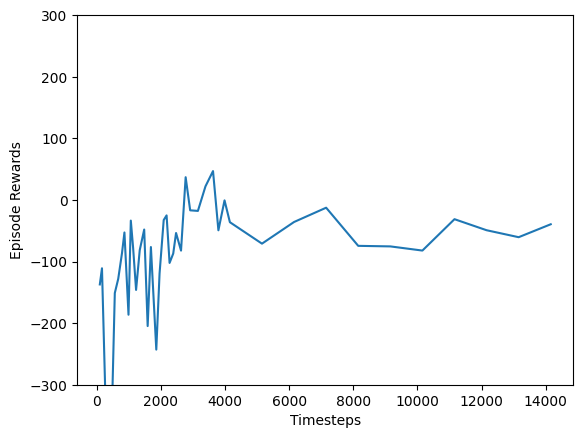

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

# Double DQN: Reduces overestimation bias, leading to more stable training.

### Importing necessary libraries

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import create_mlp
from torch import nn

Now, let us setup our environment.

In [ ]:
# Set the logging directory
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)

env = Monitor(env, log_dir)

Now, let us setup our model and the DDQN algorithm.

In [ ]:
# Define the policy architecture
nn_layers = [512, 256]  # Example architecture with two layers of 256 units each
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)

# Setup the EvalCallback to evaluate and log performance periodically
callback = EvalCallback(env, log_path=log_dir, deterministic=True)

In [ ]:
# Configure and create the DQN model, which will use Double Q-learning by default
model = DQN("MlpPolicy",
            env,
            policy_kwargs=policy_kwargs,
            learning_rate=1e-3,
            batch_size=32,  # Use a larger batch size for better learning
            buffer_size=50000,  # A larger replay buffer is typically used
            learning_starts=1000,  # Start learning after filling some buffer
            gamma=0.99,  # Discount factor
            tau=1.0,  # Soft update coefficient for the target network
            target_update_interval=1000,  # How often to update the target network
            train_freq=(4, "step"),  # Train every 4 steps
            max_grad_norm=10,  # Gradient clipping
            exploration_initial_eps=1.0,  # Initial exploration rate
            exploration_fraction=0.1,  # Fraction over which exploration rate is reduced
            exploration_final_eps=0.01,  # Final exploration rate
            gradient_steps=1,  # Number of gradient steps
            seed=1,  # Seed for random number generators
            verbose=1)  # Set verbose to 1 to observe training logs


Using cpu device
Wrapping the env in a DummyVecEnv.


### Train the model

In [ ]:
# Train the model
model.learn(total_timesteps=200000, callback=callback)

# Save the model
model.save(log_dir + "dqn_lunarlander")



----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -218     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5288     |
|    time_elapsed     | 0        |
|    total_timesteps  | 406      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.1     |
|    ep_rew_mean      | -219     |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5221     |
|    time_elapsed     | 0        |
|    total_timesteps  | 745      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.4     |
|    ep_rew_mean      | -219     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes       

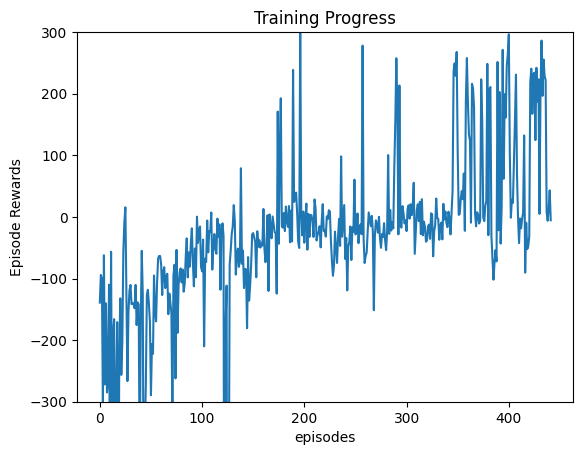

In [ ]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt

results_path = log_dir  # Update this if needed
x, y = ts2xy(load_results(results_path), 'episodes')

# Plot the results
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('episodes')
plt.ylabel('Episode Rewards')
plt.title('Training Progress')
plt.show()


Now, let us look at the visual performance of the lander.

In [ ]:
import os
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import RecordVideo

# Set the logging directory and video directory
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Load the trained model
model = DQN.load(log_dir + "dqn_lunarlander")

# Set up the environment with 'rgb_array' mode for rendering
env_name = 'LunarLander-v2'
video_dir = os.path.join(log_dir, "videos/")
os.makedirs(video_dir, exist_ok=True)

# Create the environment with 'rgb_array' render mode and wrap with video recording
env = gym.make(env_name, render_mode='rgb_array')
env = Monitor(env, log_dir)  # Monitor for logging
env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True)

# Reset the environment and handle the returned observation and info
obs, info = env.reset()  # Gym API now returns both obs and info

# Run the trained agent and record video
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()  # Render each step for recording

env.close()

# Check if video files are generated
print(f"Video files saved in: {video_dir}")
print(f"Files in video directory: {os.listdir(video_dir)}")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /tmp/gym/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() i

Video files saved in: /tmp/gym/videos/
Files in video directory: ['rl-video-episode-0.mp4', 'rl-video-episode-0.meta.json']


###  Dueling DQN: Separates the state value and action advantage, enhancing learning efficiency.

In [ ]:
import os
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Set the logging directory
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment and monitor for logging
env_name = 'LunarLander-v2'
env = gym.make(env_name)
env = Monitor(env, log_dir)  # Wrap the environment for logging

# Check if environment is correctly wrapped
print(f"Logging data to: {log_dir}")

# Custom policy kwargs for dueling architecture
policy_kwargs = dict(
    net_arch=[512, 256],
)

# Configure and create the DQN model
model = DQN("MlpPolicy",
            env,
            policy_kwargs=policy_kwargs,
            learning_rate=1e-3,
            batch_size=32,
            buffer_size=50000,
            learning_starts=1000,
            gamma=0.99,
            tau=1.0,
            target_update_interval=1000,
            train_freq=(4, "step"),
            max_grad_norm=10,
            exploration_initial_eps=1.0,
            exploration_fraction=0.1,
            exploration_final_eps=0.01,
            gradient_steps=1,
            seed=1,
            verbose=1)



Logging data to: /tmp/gym/
Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
# Train the model
model.learn(total_timesteps=200000)  # Reduced timesteps for quick testing

# Save the trained model
model.save("dueling_dqn_lunar_lander")

# Check if log files are being generated
print(f"Files in log directory: {os.listdir(log_dir)}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 82.5     |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5091     |
|    time_elapsed     | 0        |
|    total_timesteps  | 330      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.5     |
|    ep_rew_mean      | -175     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5444     |
|    time_elapsed     | 0        |
|    total_timesteps  | 684      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.2     |
|    ep_rew_mean      | -194     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes       

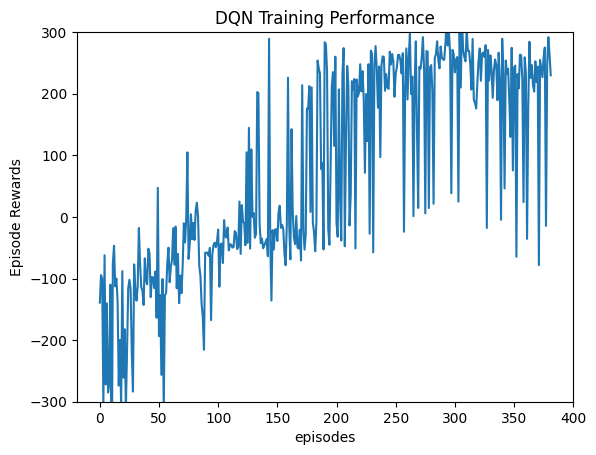

In [ ]:
# Plot the results
x, y = ts2xy(load_results(log_dir), 'episodes')  # Organizing the logged results in a clean format for plotting

if len(x) > 0 and len(y) > 0:  # Ensure there is data to plot
    plt.plot(x, y)
    plt.ylim([-300, 300])  # Set y-axis limits to improve clarity
    plt.xlabel('episodes')
    plt.ylabel('Episode Rewards')
    plt.title('DQN Training Performance')
    plt.show()
else:
    print("No data found to plot. Ensure that training has been logged properly.")


In [ ]:
!apt-get install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.


In [ ]:
import os
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import RecordVideo

# Set the logging directory and video directory
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Load the trained model
model = DQN.load("dueling_dqn_lunar_lander")

# Set up the environment with 'rgb_array' mode for rendering
env_name = 'LunarLander-v2'
video_dir = os.path.join(log_dir, "videos/")
os.makedirs(video_dir, exist_ok=True)

# Create the environment with 'rgb_array' render mode and wrap with video recording
env = gym.make(env_name, render_mode='rgb_array')
env = Monitor(env, log_dir)  # Monitor for logging
env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True)

# Reset the environment and handle the returned observation and info
obs, info = env.reset()  # Gym API now returns both obs and info

# Run the trained agent and record video
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()  # Render each step for recording

env.close()

# Check if video files are generated
print(f"Video files saved in: {video_dir}")
print(f"Files in log directory: {os.listdir(video_dir)}")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /tmp/gym/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() i

Video files saved in: /tmp/gym/videos/
Files in log directory: ['rl-video-episode-0.mp4', 'rl-video-episode-0.meta.json']


In [ ]:
import os

video_file = '/tmp/gym/videos/rl-video-episode-0.mp4'
print(f"Video file exists: {os.path.exists(video_file)}")


Video file exists: False


In [ ]:
from IPython.display import HTML

# Embed the video using HTML
video_file = '/tmp/gym/videos/rl-video-episode-0.mp4'
HTML(f'<video width="640" height="480" controls><source src="{video_file}" type="video/mp4"></video>')

